## **EXP2 Predicting Missing Cell-Types from Bulks using CIBERSORTx Residual**

*This file requieres pseudobulks to be processed and CIBERSORTx to be run.*

*See preprocessing/EXP2_pbmc_pseudos.ipynb and preprocessing/EXP2_ciber_bayes_prep.ipynb for details.**

**Summary:**
Increasing the number of missing celltypes, using random proportions pseudobulks. Then attempting to extract missing cell type information from residual. 

The residual is calculated in three different ways named: Residual (comparing NNLS calculated proportions to pseudobulks), Residual_diffbase (using different baseline being comapred to), and Residual_realref (using a "real" reference profile for cell lines).

**Hypothesis:**
Deleting cell types from NNLS reference will create a residual from which we can extract missing cell type information. 

**Deconv. Method:**
CIBERSORTx

**Factorization Methods:**
NMF


*This file is intended to be run individually or through Papermill in EXP2.py. See EXP2.py for details*

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

These parameters are set in EXP2.py file.

In [2]:
#####################
### set the study ###
#####################
#these parameters are set in papermill 
res_name = "MCT_pbmc_EXP2"
pseudos_name = "MCT_pbmc_EXP1"
path = "/../data/"
aug_data_path = "/../data/EXP2/cibersort/"
data_path = "/../data/EXP1/"
cibersort_path = "/../data/EXP2/cibersort_results/"
num_missing_cells = [0,1,2,3,4]
nmf_cut = "minimum_value"
num_samples = 10000
path_results = "/../results/EXP2/"
data_type = "pbmc3k/"
noise_type = "nonoise"
prop_type = 'random'

In [3]:
# Parameters
res_name = "MCT_pbmc_EXP2"
pseudos_name = "MCT_pbmc_EXP1"
prop_type = "random"
data_type = "pbmc3k/"
path = "/data/"
aug_data_path = "/data/EXP2/cibersort/"
data_path = "/data/EXP1/"
cibersort_path = "/data/EXP2/cibersort_results/"
noise_type = "nonoise"
random_seed = 88
path_results = "/results/EXP2/"
num_missing_cells = [0, 1, 2, 3, 4]
num_samples = 10000
nmf_cut = "minimum_value"
kernel_name = "env_ml"


In [4]:
#Parameters into paths
actual_path = os.getcwd()
path = f"{actual_path}{path}"
aug_data_path = f"{actual_path}{aug_data_path}"
data_path = f"{actual_path}{data_path}"
cibersort_path = f"{actual_path}{cibersort_path}"
path_results = f"{actual_path}{path_results}"
bulk_type = f"{prop_type}prop_{noise_type}"

## Import the previously processed datasets. 

In [5]:
pseudo_path = os.path.join(aug_data_path, f"{data_type}/{res_name}_{bulk_type}_mixture.txt")
pseudo_path = Path(pseudo_path)
# Open the file of mixture used
pseudo_df = pd.read_csv(pseudo_path, sep="\t")
#extracting gene_ids and setting as columns
pseudo_df.rename(columns = {'Unnamed: 0':'gene_ids'}, inplace = True)
gene_ids = pseudo_df["gene_ids"]
pseudo_df = pseudo_df.T
pseudo_df.columns = gene_ids
pseudo_df = pseudo_df.drop(labels = "gene_ids")
pseudo_df_copy = pseudo_df.copy()
pseudo_df

gene_ids,AL627309.1,AP006222.2,RP11-206L10.2,RP11-206L10.9,LINC00115,NOC2L,KLHL17,PLEKHN1,RP11-54O7.17,HES4,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC145212.1,AL592183.1,AL354822.1,PNRC2-1,SRSF10-1
0,19.0,8.0,6.0,7.0,34.0,582.0,12.0,15.0,15.0,923.0,...,802.0,26434.0,4813.0,552.0,23069.0,34.0,628.0,29.0,198.0,122.0
1,8.0,2.0,3.0,4.0,42.0,701.0,19.0,16.0,11.0,982.0,...,881.0,24704.0,4466.0,508.0,20935.0,23.0,699.0,28.0,217.0,143.0
2,20.0,8.0,3.0,11.0,51.0,578.0,8.0,23.0,13.0,1047.0,...,781.0,25360.0,4773.0,539.0,21418.0,44.0,577.0,28.0,222.0,134.0
3,31.0,8.0,2.0,14.0,33.0,591.0,19.0,19.0,9.0,1081.0,...,852.0,24709.0,4791.0,532.0,21917.0,34.0,621.0,19.0,188.0,109.0
4,9.0,0.0,3.0,8.0,55.0,648.0,13.0,13.0,2.0,600.0,...,821.0,22967.0,3998.0,500.0,19232.0,33.0,679.0,16.0,190.0,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23.0,4.0,4.0,14.0,54.0,613.0,19.0,8.0,12.0,1757.0,...,822.0,26167.0,5128.0,505.0,22174.0,52.0,614.0,36.0,191.0,137.0
996,9.0,4.0,5.0,6.0,37.0,602.0,18.0,8.0,7.0,1025.0,...,869.0,27033.0,4868.0,526.0,22346.0,39.0,703.0,26.0,243.0,178.0
997,9.0,9.0,4.0,9.0,37.0,578.0,16.0,15.0,3.0,424.0,...,819.0,24436.0,4199.0,537.0,21359.0,30.0,661.0,12.0,198.0,113.0
998,7.0,3.0,12.0,7.0,39.0,651.0,20.0,12.0,3.0,817.0,...,798.0,24564.0,3830.0,402.0,19331.0,29.0,790.0,23.0,183.0,125.0


In [6]:
#and importing anndata object
adata_path = os.path.join(data_path, f"{pseudos_name}_adata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata = sc.read_h5ad(adata_path)
sn_adata_copy = sn_adata.copy()
sn_adata

AnnData object with n_obs × n_vars = 2589 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'scpred_CellType', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_types_colors', 'leiden', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [7]:
#QC
print(Counter(sn_adata.obs["cell_types"]))
# define the number of cells and the list of missing cell counts
num_cells = len(sn_adata.obs.cell_types.unique())
cell_order = sn_adata.obs.cell_types.unique()

Counter({'CD4 T': 1119, 'CD14 Monocytes': 448, 'B': 342, 'CD8 T': 328, 'FCGR3A Monocytes': 188, 'NK': 164})


## Making Cell Type Reference:

In [8]:
# Making cell type reference without scaling
cell_types = sn_adata.obs["cell_types"].unique()
gene_ids = sn_adata.var["gene_ids"]
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)
for cell_type in cell_types:
    cell_df = sn_adata[sn_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw.index = gene_ids.index

In [9]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw.values
clip_upper = np.quantile(ref_raw_val, 0.95)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = cell_types)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = cell_types)
ref_df.index = gene_ids.index
ref_df_copy = ref_df.copy()

## **Reading In and QCing the CIBERSORTx Results:**

CIBERSORTx Results:

In [10]:
#import all CIBERSORTx results and real proportions
cibersort_prop = dict()
real_prop_reb = dict()
real_prop = dict()
ref_cibersort = dict()
for num in num_missing_cells:
    #import cibersort proportions
    cibersort_results_path = os.path.join(cibersort_path, f"{data_type}/{num}_missing/CIBERSORTx_Results.txt")
    cibersort_results_path = Path(cibersort_results_path)
    # Open the CSV file in read mode
    cibersort_prop[num] = pd.read_csv(cibersort_results_path, sep="\t")
    cibersort_prop[num] = cibersort_prop[num].drop(labels = ["Mixture", "P-value", "Correlation", "RMSE"], axis = 1)
    cibersort_prop[num]

    #real proportions
    realprop_results_path = os.path.join(aug_data_path, f"{data_type}/{res_name}_{num}missing_{bulk_type}_prop.csv")
    realprop_results_path = Path(realprop_results_path)
    # Open the CSV file in read mode
    real_prop[num] = pd.read_csv(realprop_results_path, sep=",")

    #real rebalanced proportions
    real_prop_reb[num] = real_prop[num] 

    #and the reference used in cibersort
    ref_results_path = os.path.join(cibersort_path, f"{data_type}/{num}_missing/CIBERSORTx_{res_name}_{bulk_type}_{num}missing_signal_inferred_phenoclasses.CIBERSORTx_{res_name}_{bulk_type}_{num}missing_signal_inferred_refsample.bm.K999.txt")
    ref_results_path = Path(ref_results_path)
    # Open the CSV file in read mode
    ref_cibersort[num] = pd.read_csv(ref_results_path, sep="\t")
    ref_cibersort[num] = ref_cibersort[num].rename(columns = {'NAME':'gene_ids'})
    ref_cibersort[num].index = ref_cibersort[num]["gene_ids"]
    gene_ids[num] = ref_cibersort[num].index
    ref_cibersort[num] = ref_cibersort[num].drop(labels= "gene_ids", axis = 1)


/projects/aivich@xsede.org/code-server/tmp/ipykernel_2052293/4004390523.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_ids[num] = ref_cibersort[num].index


In [11]:
#matching genes in reference, pseudobulks in gene_ids[num]
sn_adata = dict()
ref_df = dict()
gene_ids = dict()
#copying pseudobulks
pseudo_df_copy = pseudo_df.copy()
pseudo_df = dict()
for num in num_missing_cells:
    #cutting to gene_ids in reference
    pseudo_df[num] = pseudo_df_copy.copy()
    gene_ids[num] = pseudo_df[num].columns
    sn_adata[num] = sn_adata_copy[:, gene_ids[num]]
    ref_df[num] = ref_df_copy.loc[gene_ids[num], :]
    print(gene_ids[num].shape)
    #and  deleting missing cells form reference
    ref_df[num] = ref_df[num].filter(ref_cibersort[num].columns)

(13714,)
(13714,)


(13714,)
(13714,)
(13714,)


In [12]:
#using rebalanced proportions (summing to one) after deleting cell types
real_prop = real_prop_reb

QC imported files:

In [13]:
cibersort_prop[0]

,CD8 T,B,CD4 T,FCGR3A Monocytes,NK,CD14 Monocytes
0,0.260867,0.084106,0.109972,0.308352,0.072814,0.163889
1,0.139487,0.099854,0.124524,0.340668,0.262156,0.033312
2,0.089663,0.061992,0.196743,0.332877,0.100703,0.218022
3,0.142050,0.041674,0.057017,0.324341,0.138373,0.296544
4,0.078919,0.121714,0.133163,0.197926,0.309841,0.158438
...,...,...,...,...,...,...
995,0.060257,0.073991,0.020310,0.504959,0.069425,0.271058
996,0.080016,0.049439,0.445240,0.358137,0.011795,0.055373
997,0.233915,0.085106,0.273593,0.155899,0.126692,0.124796
998,0.062715,0.405641,0.040802,0.287923,0.144775,0.058144


In [14]:
real_prop[0]

,CD8 T,B,CD4 T,FCGR3A Monocytes,NK,CD14 Monocytes
0,0.3200,0.0964,0.1202,0.1966,0.0890,0.1778
1,0.1680,0.1220,0.1248,0.2252,0.3254,0.0346
2,0.0980,0.0770,0.2296,0.2202,0.1296,0.2456
3,0.1890,0.0474,0.0418,0.2210,0.1826,0.3182
4,0.0666,0.1368,0.1512,0.1152,0.3702,0.1600
...,...,...,...,...,...,...
995,0.0806,0.1074,0.0076,0.3762,0.0988,0.3294
996,0.0804,0.0580,0.5474,0.2348,0.0176,0.0618
997,0.2642,0.0908,0.2782,0.0868,0.1510,0.1290
998,0.0524,0.5086,0.0306,0.1688,0.1762,0.0634


In [15]:
real_prop[0]

,CD8 T,B,CD4 T,FCGR3A Monocytes,NK,CD14 Monocytes
0,0.3200,0.0964,0.1202,0.1966,0.0890,0.1778
1,0.1680,0.1220,0.1248,0.2252,0.3254,0.0346
2,0.0980,0.0770,0.2296,0.2202,0.1296,0.2456
3,0.1890,0.0474,0.0418,0.2210,0.1826,0.3182
4,0.0666,0.1368,0.1512,0.1152,0.3702,0.1600
...,...,...,...,...,...,...
995,0.0806,0.1074,0.0076,0.3762,0.0988,0.3294
996,0.0804,0.0580,0.5474,0.2348,0.0176,0.0618
997,0.2642,0.0908,0.2782,0.0868,0.1510,0.1290
998,0.0524,0.5086,0.0306,0.1688,0.1762,0.0634


In [16]:
ref_cibersort[0]

,CD8 T,B,CD4 T,FCGR3A Monocytes,NK,CD14 Monocytes
gene_ids,,,,,,
AAK1,115.281707,1.000000,126.822747,1.000000,108.127718,1.000000
AAMP,1.000000,145.506370,1.000000,65.961735,1.000000,1.000000
AATF,1.000000,1.000000,1.000000,67.724959,118.550772,1.000000
ABHD14A,107.149548,1.000000,1.000000,1.000000,101.949909,1.000000
ABHD14B,126.792633,1.000000,125.104192,1.000000,118.881993,1.000000
...,...,...,...,...,...,...
ZNF703,1.000000,1.000000,1.000000,86.703939,1.000000,1.000000
ZNRD1,107.546819,1.000000,1.000000,1.000000,1.000000,89.771078
ZRANB2,1.000000,106.932381,1.000000,1.000000,1.000000,1.000000


In [17]:
pseudo_df[0]

gene_ids,AL627309.1,AP006222.2,RP11-206L10.2,RP11-206L10.9,LINC00115,NOC2L,KLHL17,PLEKHN1,RP11-54O7.17,HES4,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC145212.1,AL592183.1,AL354822.1,PNRC2-1,SRSF10-1
0,19.0,8.0,6.0,7.0,34.0,582.0,12.0,15.0,15.0,923.0,...,802.0,26434.0,4813.0,552.0,23069.0,34.0,628.0,29.0,198.0,122.0
1,8.0,2.0,3.0,4.0,42.0,701.0,19.0,16.0,11.0,982.0,...,881.0,24704.0,4466.0,508.0,20935.0,23.0,699.0,28.0,217.0,143.0
2,20.0,8.0,3.0,11.0,51.0,578.0,8.0,23.0,13.0,1047.0,...,781.0,25360.0,4773.0,539.0,21418.0,44.0,577.0,28.0,222.0,134.0
3,31.0,8.0,2.0,14.0,33.0,591.0,19.0,19.0,9.0,1081.0,...,852.0,24709.0,4791.0,532.0,21917.0,34.0,621.0,19.0,188.0,109.0
4,9.0,0.0,3.0,8.0,55.0,648.0,13.0,13.0,2.0,600.0,...,821.0,22967.0,3998.0,500.0,19232.0,33.0,679.0,16.0,190.0,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23.0,4.0,4.0,14.0,54.0,613.0,19.0,8.0,12.0,1757.0,...,822.0,26167.0,5128.0,505.0,22174.0,52.0,614.0,36.0,191.0,137.0
996,9.0,4.0,5.0,6.0,37.0,602.0,18.0,8.0,7.0,1025.0,...,869.0,27033.0,4868.0,526.0,22346.0,39.0,703.0,26.0,243.0,178.0
997,9.0,9.0,4.0,9.0,37.0,578.0,16.0,15.0,3.0,424.0,...,819.0,24436.0,4199.0,537.0,21359.0,30.0,661.0,12.0,198.0,113.0
998,7.0,3.0,12.0,7.0,39.0,651.0,20.0,12.0,3.0,817.0,...,798.0,24564.0,3830.0,402.0,19331.0,29.0,790.0,23.0,183.0,125.0


In [18]:
ref_df[0]

,CD8 T,B,CD4 T,FCGR3A Monocytes,NK,CD14 Monocytes
gene_ids,,,,,,
AL627309.1,0.008763,0.000000,0.005045,0.000000,0.000000,0.033990
AP006222.2,0.006639,0.000000,0.002390,0.000000,0.000000,0.005576
RP11-206L10.2,0.000000,0.020447,0.001328,0.000000,0.000000,0.000000
RP11-206L10.9,0.000000,0.000000,0.000000,0.013012,0.000000,0.011153
LINC00115,0.008763,0.024165,0.015402,0.027351,0.028679,0.028148
...,...,...,...,...,...,...
AC145212.1,0.005576,0.014339,0.011949,0.033459,0.000000,0.038238
AL592183.1,0.293426,0.475059,0.383977,0.350253,0.399644,0.269262
AL354822.1,0.000000,0.013012,0.002655,0.046205,0.000000,0.007701


In [19]:
###QC dimensions
for num in gene_ids:
    print(gene_ids[num].shape)
    print(ref_df[num].shape)
    print(pseudo_df[num].shape)
    print(ref_cibersort[num].shape)

(13714,)
(13714, 6)
(1000, 13714)
(1338, 6)
(13714,)
(13714, 5)
(1000, 13714)
(1435, 5)
(13714,)
(13714, 4)
(1000, 13714)
(1307, 4)
(13714,)
(13714, 3)
(1000, 13714)
(736, 3)
(13714,)
(13714, 2)
(1000, 13714)
(610, 2)


Visualize CIBERSORTx proportions:

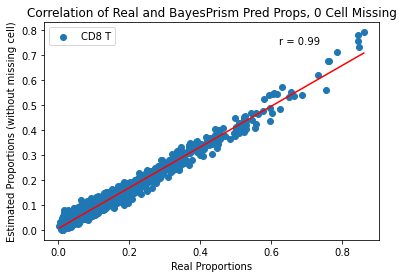

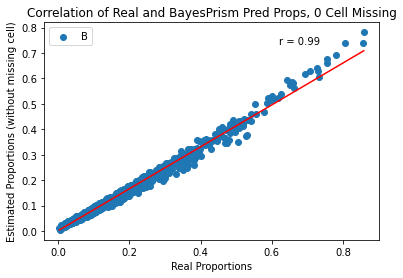

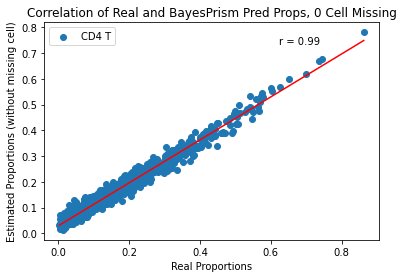

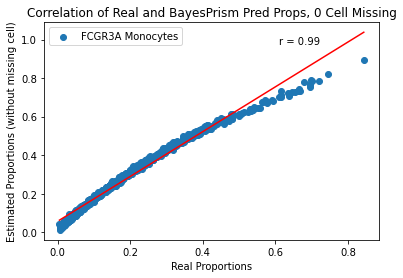

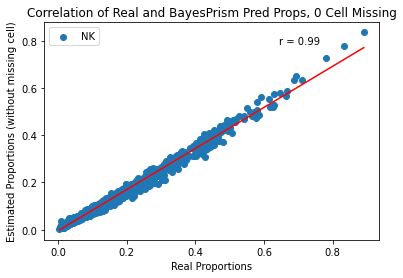

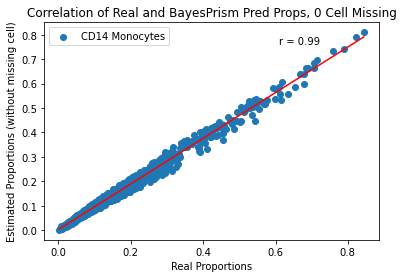

In [20]:
#Evaluation performance with no cell types missing, expect to be very close to 1.
num = 0 
for col_cell in real_prop[num].columns:
    x = real_prop[num][col_cell].values.astype(float)
    y = cibersort_prop[num][col_cell].values.astype(float)
    correlation_coefficient = np.corrcoef(x, y)[0,1]
    plt.scatter(x, y, label= f"{col_cell}")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = "red")
    r, p = stats.pearsonr(x, y)
    plt.annotate('r = {:.2f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and BayesPrism Pred Props, {num} Cell Missing')
    plt.legend()
    plt.show()

Real Proportions shape: (1000, 6)
Estimated Proportions shape: (1000, 6)


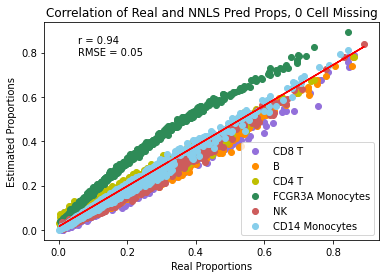

Real Proportions shape: (1000, 5)
Estimated Proportions shape: (1000, 5)


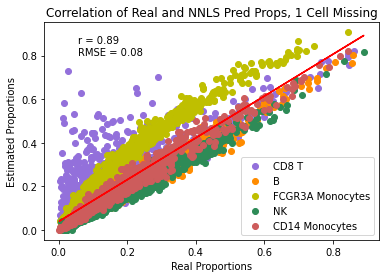

Real Proportions shape: (1000, 4)
Estimated Proportions shape: (1000, 4)


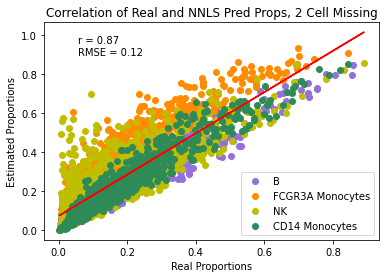

Real Proportions shape: (1000, 3)
Estimated Proportions shape: (1000, 3)


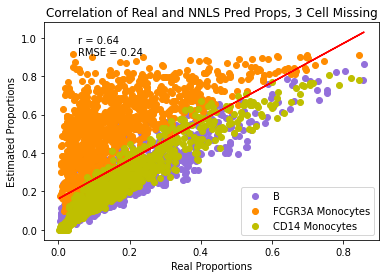

Real Proportions shape: (1000, 2)
Estimated Proportions shape: (1000, 2)


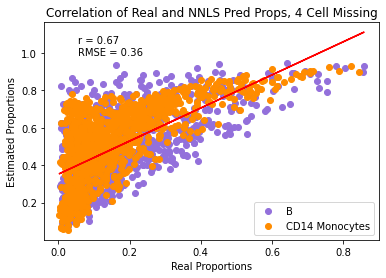

In [21]:
#Comparing performance for all cell types with num_cells_missing.
# Define colormap for coloring cell types
cmap = get_cmap('tab20') 
color_dict = {cell_type: cmap(i) for i, cell_type in enumerate(ref_cibersort[0].columns.tolist())}
custom_colors = ['mediumpurple', 'darkorange', 'y', 'seagreen', 'indianred', 'skyblue']

for num in num_missing_cells:
    real_proportions = real_prop_reb[num].values.astype(float) #real proportions of present cells
    estimated_proportions = cibersort_prop[num].values.astype(float) #estimated proportions of present cells.
    cell_types = real_prop_reb[num].columns.tolist() 
    # Print the shapes of the matrices
    print("Real Proportions shape:", real_proportions.shape)
    print("Estimated Proportions shape:", estimated_proportions.shape)
    correlation_coefficient = np.corrcoef(real_proportions, estimated_proportions)[0, 1]
    #scatter plot with colored points for each cell type
    fig, ax = plt.subplots()
    for i, cell_type in enumerate(cell_types):
        x = real_proportions[:, i]
        y = estimated_proportions[:, i]
        # Use custom colors
        color = custom_colors[i % len(custom_colors)]
        ax.scatter(x, y, label=cell_type, color=color)
    # Fit a regression line
    m, b = np.polyfit(real_proportions.flatten(), estimated_proportions.flatten(), 1)
    plt.plot(real_proportions.flatten(), m * real_proportions.flatten() + b, color="red")
    
    # Calculate r
    r, p = stats.pearsonr(real_proportions.flatten(), estimated_proportions.flatten())
    
    # Calculate RMSE
    rmse = vp.rmse(real_proportions, estimated_proportions)
    
    # And annotate
    plt.annotate(f'r = {r:.2f}\nRMSE = {rmse:.2f}', xy=(0.1, 0.85), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions')
    plt.title(f'Correlation of Real and NNLS Pred Props, {num} Cell Missing')
    plt.legend(loc='lower right')  #show the cell type labels in the legend
    plt.show()

And save results:

In [22]:
# Iterate through num_missing_cells
real_df = pd.DataFrame()
predicted_df = pd.DataFrame()

for num in num_missing_cells:
    real_proportions = real_prop_reb[num].values.astype(float)
    estimated_proportions = cibersort_prop[num].values.astype(float)
    cell_types = real_prop_reb[num].columns.tolist()

    # Create dataframes
    real_df_current = pd.DataFrame(data=real_proportions, columns=cell_types, index=[num]*len(real_proportions))
    predicted_df_current = pd.DataFrame(data=estimated_proportions, columns=cell_types, index=[num]*len(estimated_proportions))

    real_df = pd.concat([real_df, real_df_current])
    predicted_df = pd.concat([predicted_df, predicted_df_current])


# Save dataframes to .txt files
real_filename = f"{path_results}EXP2_cibersortx_pbmc_real.txt"
predicted_filename = f"{path_results}EXP2_cibersortx_pbmc_predicted.txt"

# Save dataframes to .txt files
with open(real_filename, 'w') as file:
    real_df.to_csv(file, sep='\t', index=True, header=True, mode='w')

with open(predicted_filename, 'w') as file:
    predicted_df.to_csv(file, sep='\t', index=True, header=True, mode='w')

Compare Error: Real Proportions - Estimated Proportions 

In [23]:
#the difference between calculated and real proportions.
custom_res_tot = dict()
for num in num_missing_cells:
    custom_res_tot[num] = real_prop[num].values - cibersort_prop[num]

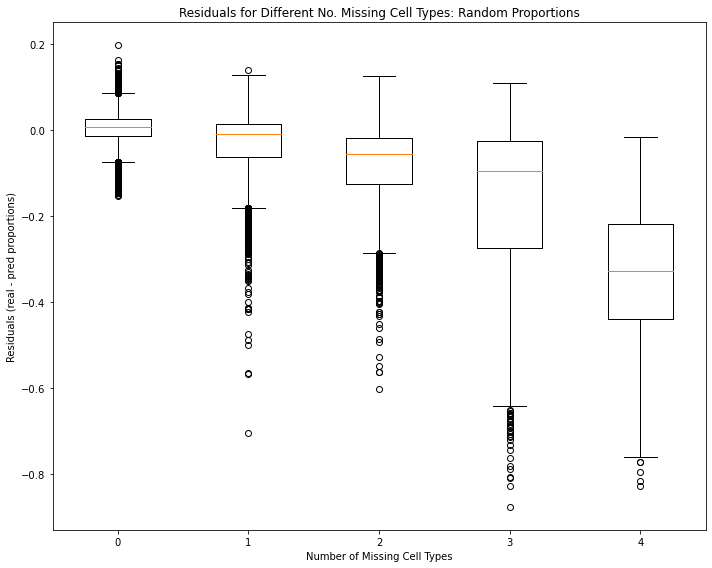

In [24]:
#Distribution of residuals as the difference between calculated and real proportions.
#the difference between calculated and real proportions.
custom_res_tot = dict()
for num in num_missing_cells:
    custom_res_tot[num] = real_prop[num].values - cibersort_prop[num]
fig, ax = plt.subplots(figsize=(10, 8))

# List to store all the residual values
residual_values = []

# Iterate over the dataframes and extract the residual values
for num_cells in num_missing_cells:
    df = custom_res_tot[num_cells]
    residuals = df.values.flatten()  # Flatten the dataframe to a 1D array
    residual_values.append(residuals)

# Plot the box and whisker plot for all the residuals
ax.boxplot(residual_values, labels=num_missing_cells)
ax.set_title("Residuals for Different No. Missing Cell Types: Random Proportions")
ax.set_xlabel("Number of Missing Cell Types")
ax.set_ylabel("Residuals (real - pred proportions)")

plt.tight_layout()
plt.show()

## **Extracting Missing Cell Information:**

In [25]:
cells_to_miss = dict()
missing_cell_tot  = dict()
for num in num_missing_cells:
    #cells that are missing
    cells_to_miss[num] = np.setdiff1d(ref_df[0].columns, ref_cibersort[num].columns)
    #extracting real proportions from missing cells
    missing_cell_tot[num] = real_prop[0][cells_to_miss[num]]
    print(f"{num} missing: {missing_cell_tot[num].shape}")

0 missing: (1000, 0)
1 missing: (1000, 1)
2 missing: (1000, 2)
3 missing: (1000, 3)
4 missing: (1000, 4)


In [26]:
# Get the corresponding missing_cell_proportions
missing_cell_prop = dict()
missing_cell_prop[0] = []
for num in num_missing_cells[1:]:
    missing_cell_prop[num] = real_prop[0][missing_cell_tot[num].columns]  
    print(f"{num} missing: prop is {missing_cell_prop[num].shape}")

1 missing: prop is (1000, 1)
2 missing: prop is (1000, 2)
3 missing: prop is (1000, 3)
4 missing: prop is (1000, 4)


## **Calculate Residuals:**

1. Residual uses:

pseudobulks (scaled) -  (reference used (ref_bp, scaled) * calculated proportions (calc_prop_tot))

In [27]:
#Residual: pseudobulks as used, minus reference of ciberef_cibersort * calculated proportions
residuals = dict()
for num in num_missing_cells:
    res = (pseudo_df[num].values) - (cibersort_prop[num] @ ref_df[num].T)
    residuals[num] = pd.DataFrame(res, columns = gene_ids[num])
residuals[3]    

gene_ids,AL627309.1,AP006222.2,RP11-206L10.2,RP11-206L10.9,LINC00115,NOC2L,KLHL17,PLEKHN1,RP11-54O7.17,HES4,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC145212.1,AL592183.1,AL354822.1,PNRC2-1,SRSF10-1
0,18.990786,7.998488,5.997265,6.989233,33.972859,581.6472,11.987405,14.995609,14.987981,922.34913,...,801.528214,26433.0,4812.0,551.723738,23068.0,33.967803,627.65501,28.968672,197.902907,121.903332
1,7.998652,1.999779,2.996238,3.989456,41.973204,700.599038,18.985472,15.999358,10.988907,981.210555,...,880.511278,24703.0,4465.0,507.708142,20934.0,22.969869,698.629997,27.961429,216.892823,142.873243
2,19.989046,7.998203,2.997901,10.988923,50.972719,577.654965,7.987721,22.99478,12.987505,1046.360417,...,780.528969,25359.0,4772.0,538.72364,21417.0,43.966964,576.663037,27.969612,221.90448,133.90844
3,30.986834,7.99784,1.998787,13.98848,32.972529,590.66428,18.988101,18.993726,8.986849,1080.371052,...,851.529357,24708.0,4790.0,531.722837,21916.0,33.965824,620.673715,18.970679,187.906354,108.914636
4,8.992081,-0.001299,2.996398,7.989714,54.973025,647.644217,12.987277,12.996226,1.988596,599.359457,...,820.530542,22966.0,3997.0,499.727239,19231.0,32.968796,678.646629,15.968614,189.902372,104.901028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,22.989346,3.998252,3.998241,13.98869,53.972673,612.650438,18.987543,7.994923,11.987289,1756.337117,...,821.525542,26166.0,5127.0,504.719747,22173.0,51.966688,613.664397,35.968719,190.903484,136.905851
996,8.996254,3.999385,4.997525,5.988768,36.972947,601.606827,17.985796,7.998215,6.987979,1024.206594,...,868.509307,27032.0,4867.0,525.704434,22345.0,38.968329,702.643568,25.962056,242.894329,177.878722
997,8.991458,8.998599,3.996109,8.989932,36.973055,577.650653,15.987531,14.995929,2.988768,423.388007,...,818.534597,24435.0,4198.0,536.731693,21358.0,29.968979,660.646349,11.969789,197.903767,112.904816
998,6.997943,2.999663,11.989993,6.993469,38.97416,650.648241,19.987375,11.99902,2.993021,816.523728,...,797.55923,24563.0,3829.0,401.764616,19330.0,28.97561,789.593564,22.972371,182.903939,124.899991


In [28]:
#scaling the residual and references
ref_df_scaled = dict()
pseudo_scaled = dict()
for num in num_missing_cells:
    #clippign before scaling to 95th pecentile
    ref_raw_val = ref_df[num].values ##reference created
    clip_upper = np.quantile(ref_raw_val, 0.90)
    ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
    #and scaling to be between values 0 and 1 
    scaler = MinMaxScaler()
    scaler.fit(ref_raw_val)
    ref_scale = scaler.transform(ref_raw_val)
    ref_df_scaled[num] = pd.DataFrame(ref_scale, index = ref_df[num].index, columns = real_prop[num].columns)
    print(ref_df_scaled[num].shape)
    #clippign before scaling to 95th pecentile
    pseudo_raw_val = pseudo_df[num][ref_df[num].index].values ##pseudobulks
    clip_upper = np.quantile(pseudo_raw_val, 0.90)
    pseudo_raw_val = np.clip(pseudo_raw_val, 0, clip_upper)
    #and scaling to be between values 0 and 1 
    scaler = MinMaxScaler()
    scaler.fit(pseudo_raw_val)
    pseudo_scale = scaler.transform(pseudo_raw_val)
    pseudo_scaled[num] = pd.DataFrame(pseudo_scale, columns = gene_ids[num])
    print(pseudo_df[num].shape)

(13714, 6)


(1000, 13714)
(13714, 5)


(1000, 13714)
(13714, 4)


(1000, 13714)
(13714, 3)


(1000, 13714)
(13714, 2)


(1000, 13714)


In [29]:
# QC of scaling
print(ref_cibersort[1].max().max())
print(ref_df_scaled[1].max().max())

print(pseudo_df[1].max().max())
print(pseudo_scaled[1].max().max())

21782.6074583839
1.0


581671.0
1.0000000000000018


In [30]:
#Residual with the scaled pseudobulk and scaled reference.
residuals_scaled = dict()
for num in num_missing_cells:
    res = (pseudo_scaled[num].values)  - (cibersort_prop[num] @ ref_df_scaled[num].T)
    residuals_scaled[num] = pd.DataFrame(res, columns = gene_ids[num])
residuals_scaled[0]    

gene_ids,AL627309.1,AP006222.2,RP11-206L10.2,RP11-206L10.9,LINC00115,NOC2L,KLHL17,PLEKHN1,RP11-54O7.17,HES4,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC145212.1,AL592183.1,AL354822.1,PNRC2-1,SRSF10-1
0,0.273462,0.464758,0.210546,0.221627,0.343575,-0.187811,0.271609,0.442503,0.504073,0.553005,...,-0.445710,-1.0,-1.0,0.033314,-1.0,0.361387,-0.354854,0.412286,0.248493,0.292874
1,0.106924,0.114822,0.102719,0.123703,0.479557,-0.008374,0.449167,0.471694,0.369087,0.623814,...,-0.221048,-1.0,-1.0,-0.080496,-1.0,0.226927,-0.208346,0.395436,0.361742,0.373960
2,0.288033,0.466016,0.104078,0.353111,0.637219,-0.212557,0.163088,0.682888,0.432857,0.566810,...,-0.550213,-1.0,-1.0,0.013324,-1.0,0.485934,-0.516061,0.393910,0.396762,0.344504
3,0.460595,0.465110,0.069569,0.451578,0.319679,-0.176182,0.452918,0.559144,0.292859,0.549971,...,-0.297255,-1.0,-1.0,-0.000607,-1.0,0.353963,-0.359379,0.256300,0.211151,0.258289
4,0.115505,-0.003459,0.101800,0.257962,0.705391,-0.083729,0.291954,0.375628,0.058954,0.305959,...,-0.412268,-1.0,-1.0,-0.060365,-1.0,0.356622,-0.263509,0.221493,0.222506,0.250897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.335107,0.231365,0.139771,0.447437,0.684604,-0.171426,0.449791,0.230346,0.392150,0.382613,...,-0.420365,-1.0,-1.0,-0.075573,-1.0,0.578434,-0.391842,0.500856,0.229068,0.343261
996,0.119351,0.231477,0.175360,0.189421,0.397613,-0.162557,0.427377,0.233448,0.230036,0.597501,...,-0.266777,-1.0,-1.0,-0.055307,-1.0,0.426289,-0.184259,0.362316,0.486215,0.490527
997,0.113654,0.523593,0.138641,0.293144,0.399047,-0.171560,0.377947,0.440047,0.095563,0.168755,...,-0.387506,-1.0,-1.0,0.002451,-1.0,0.319014,-0.285540,0.164574,0.241096,0.268504
998,0.091298,0.174791,0.411837,0.224524,0.424286,-0.080884,0.475892,0.355606,0.093930,0.483326,...,-0.448970,-1.0,-1.0,-0.265683,-1.0,0.300558,-0.009272,0.315485,0.185711,0.300476


## NMF 

Analyzing how close to negative the distributions of each residual are:

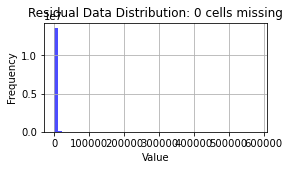

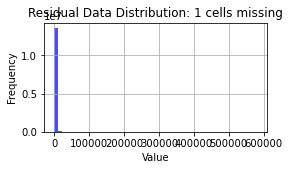

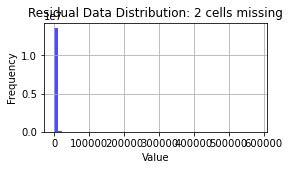

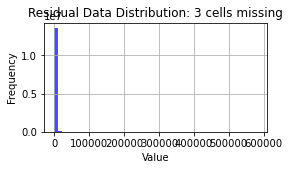

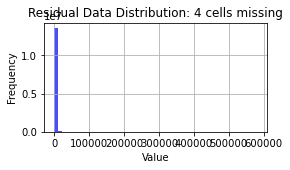

In [31]:
#distribution of residuals
for num in num_missing_cells:
    data = residuals[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

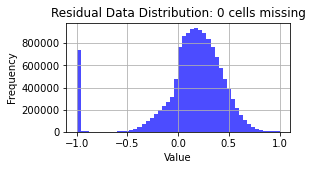

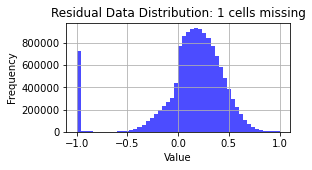

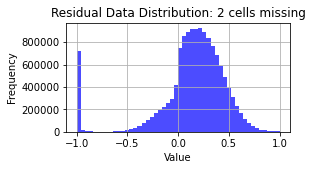

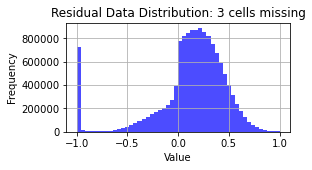

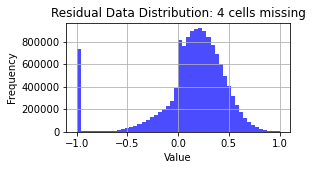

In [32]:
#distribution of residuals, but scaled
for num in num_missing_cells:
    data = residuals_scaled[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Shifting distributions according to above plots, and calculating NMF:

0.05708597180379165


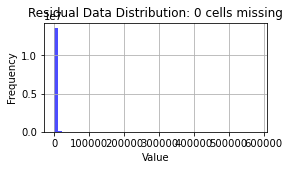

0.06525541768636642


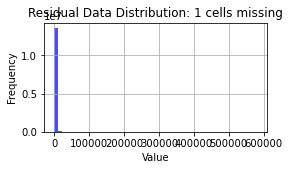

0.20930391865588202


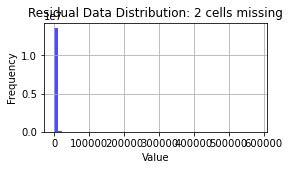

0.27758924900861515


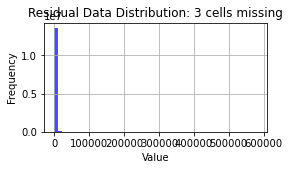

0.38697463173559454


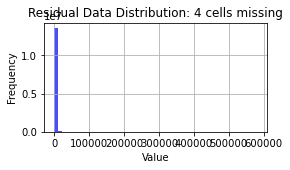

In [33]:
#shifting distribution of residuals to do NMF
residuals_shift = residuals.copy()
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift distributions minimally:
        min_val = abs(np.min(np.min(residuals[num])))
        print(min_val)
        residuals_shift[num] = residuals[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift[num][residuals_shift[num].values <= 0] = 0
    data = residuals_shift[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Shifting distributions according to above plots, and calculating NMF:

1.0000000000000018


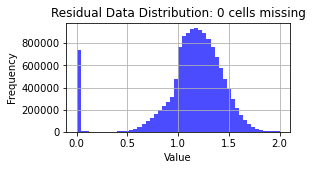

1.000000000000002


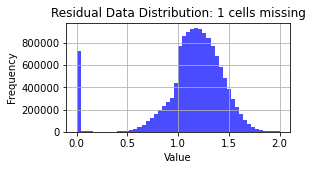

1.0000000000000013


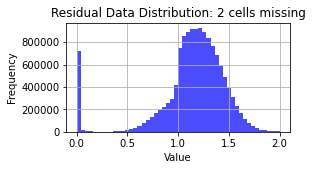

1.000000000000001


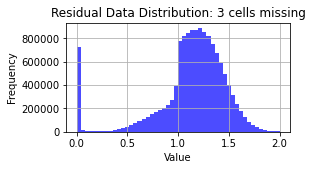

1.0000000000000009


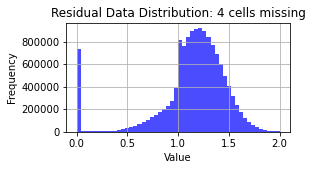

In [34]:
#shift_scaleding distribution of residuals to do NMF
residuals_shift_scaled = residuals_scaled
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift_scaled distributions minimally:
        min_val = abs(np.min(np.min(residuals_scaled[num])))
        print(min_val)
        residuals_shift_scaled[num] = residuals_scaled[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift_scaled[num][residuals_shift_scaled[num].values <= 0] = 0
    data = residuals_shift_scaled[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Residual

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


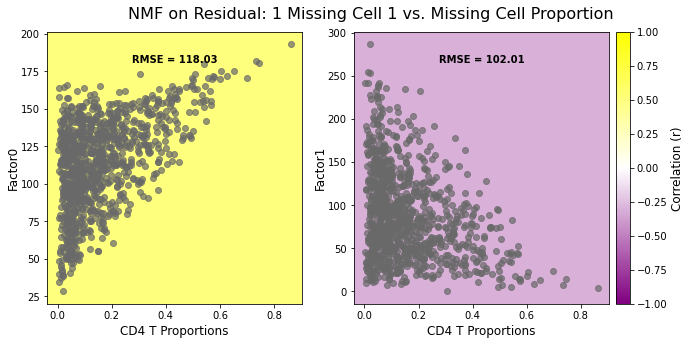

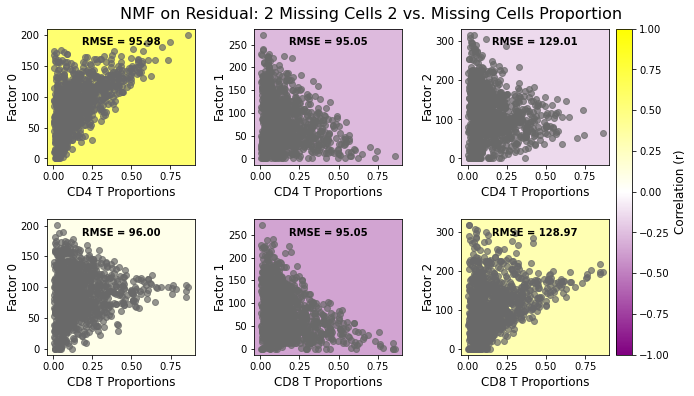

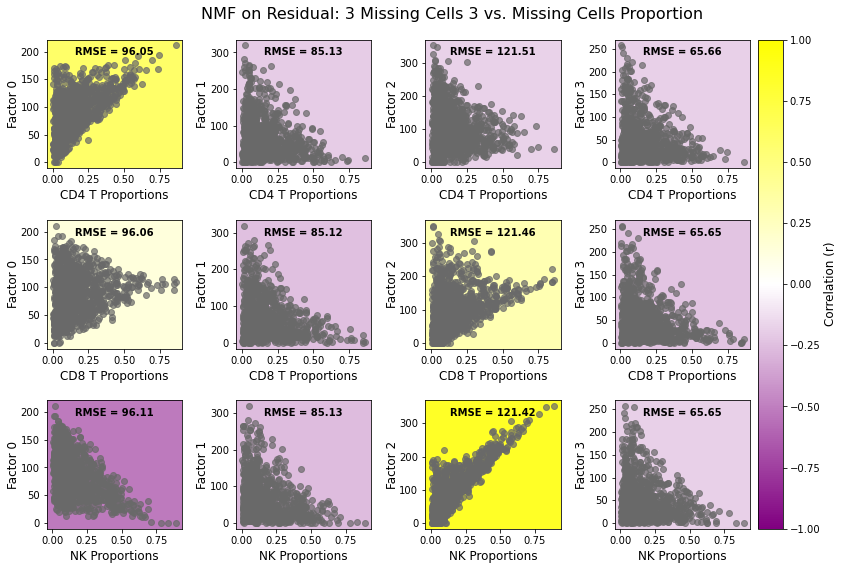

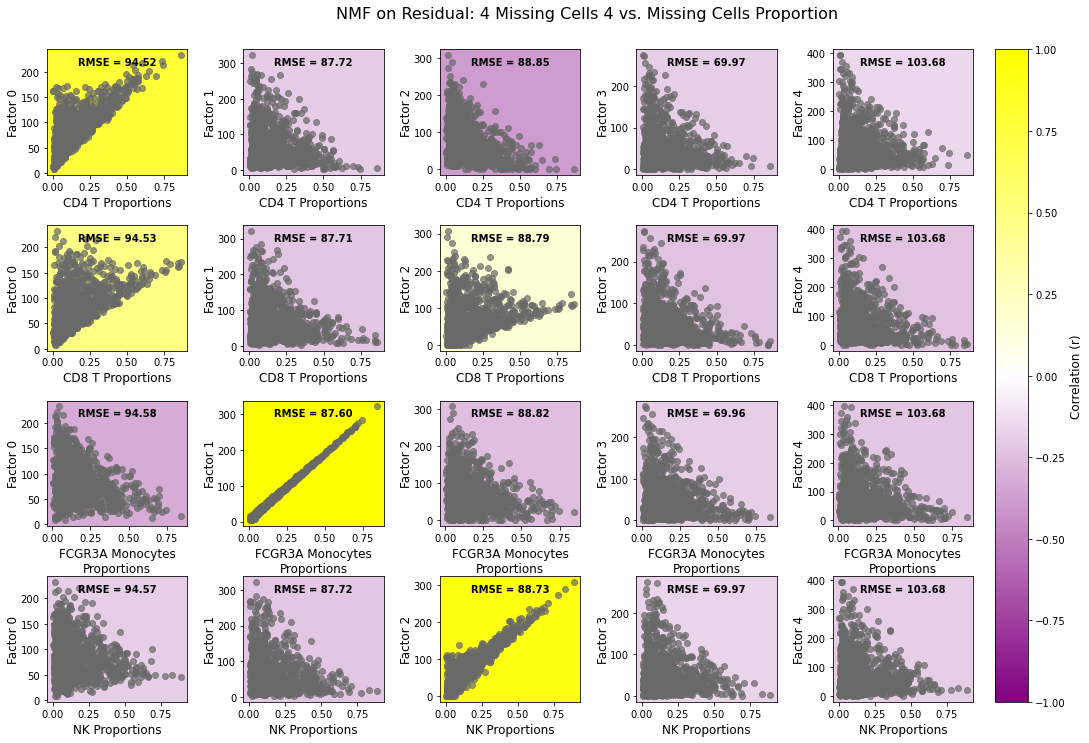

In [35]:
#NMF Residual(by sample) compared to each missing celltype proportion
#nmf on residual 1
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf, max_iter=10000, init='nndsvd')
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_rmse(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 

Residual_scaled (0 to 1)

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


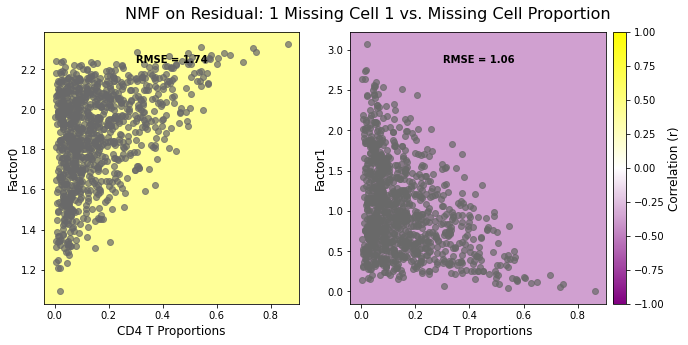

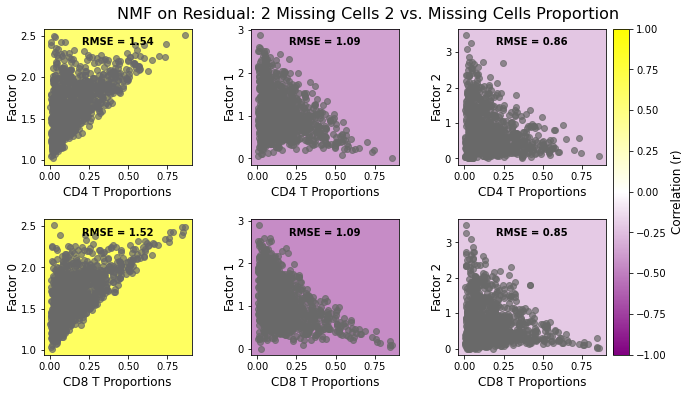

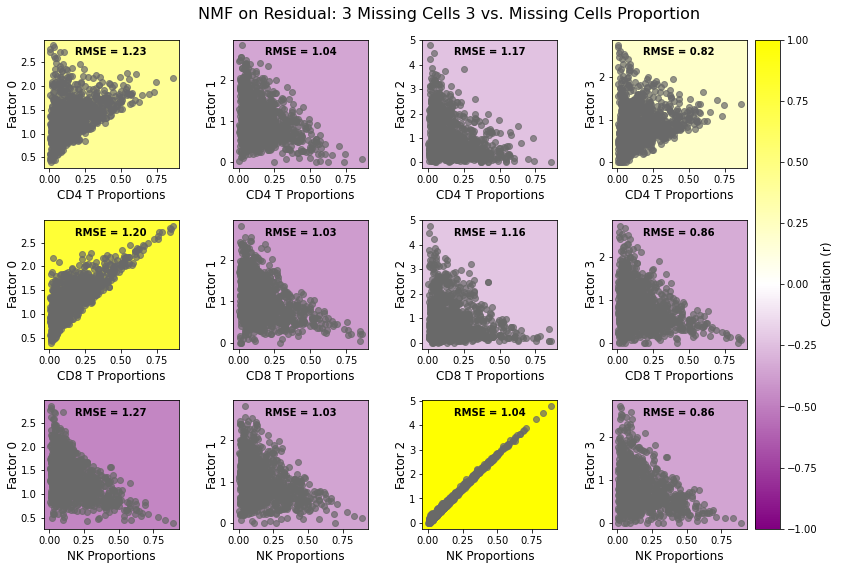

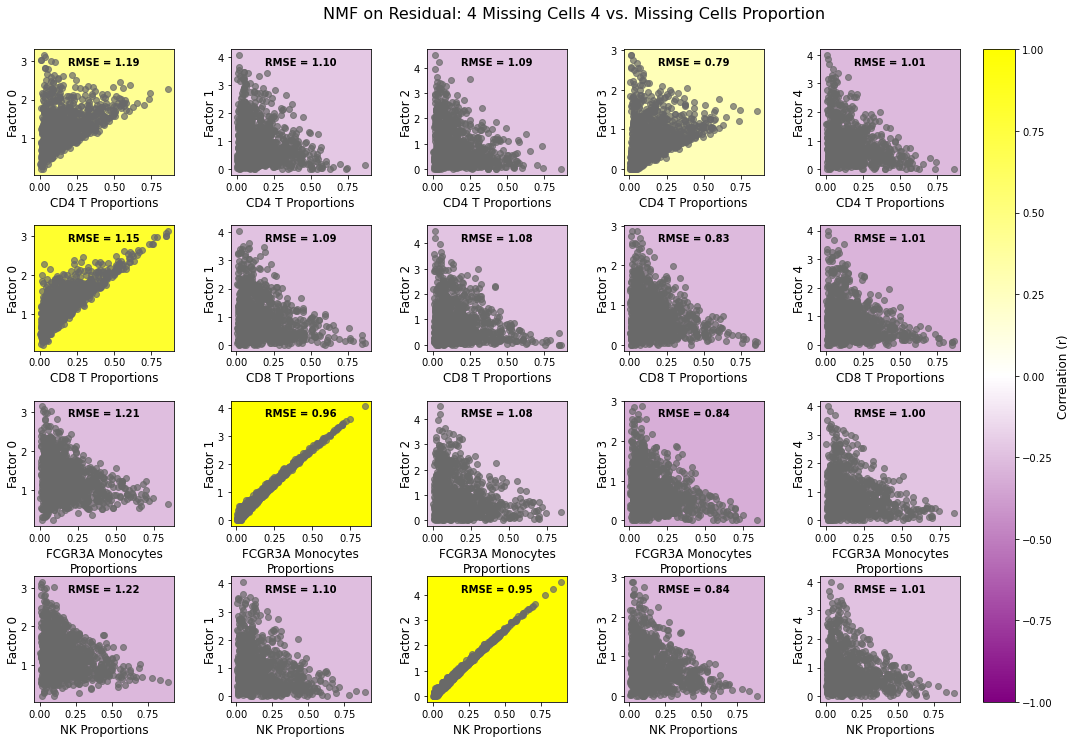

In [36]:
#NMF Residual(by sample) compared to each missing celltype proportion
#nmf on residual 1
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num + 1
    nmf = NMF(n_components = num_nmf, max_iter=10000, init='nndsvd')
    res_nmf_df = nmf.fit_transform(residuals_shift_scaled[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_rmse(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 

Same as above, but now making the NMF components be in the same scale (0 to 1).

/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


/projects/aivich@xsede.org/software/anaconda/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


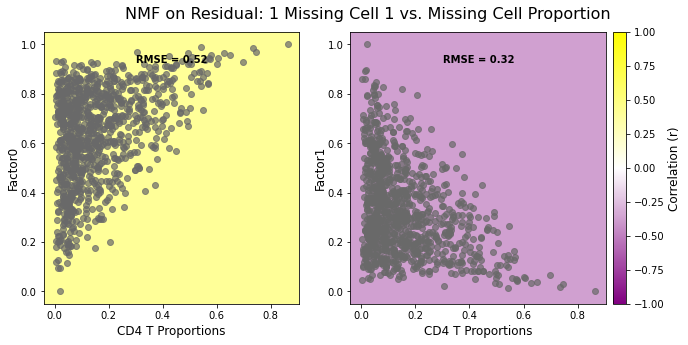

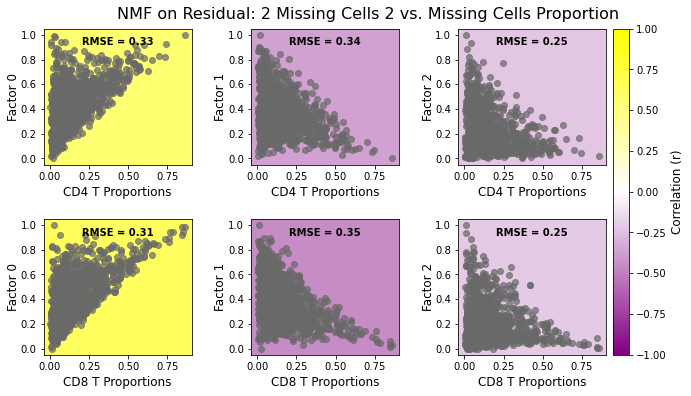

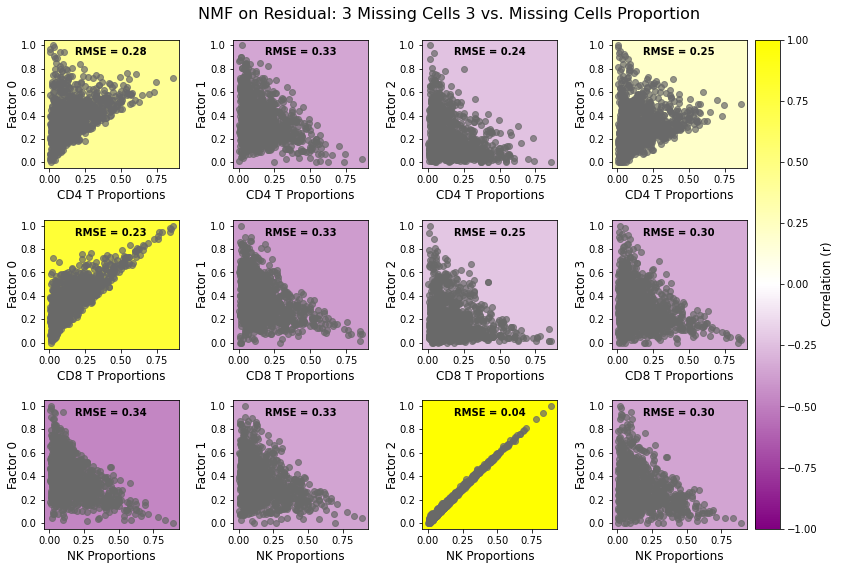

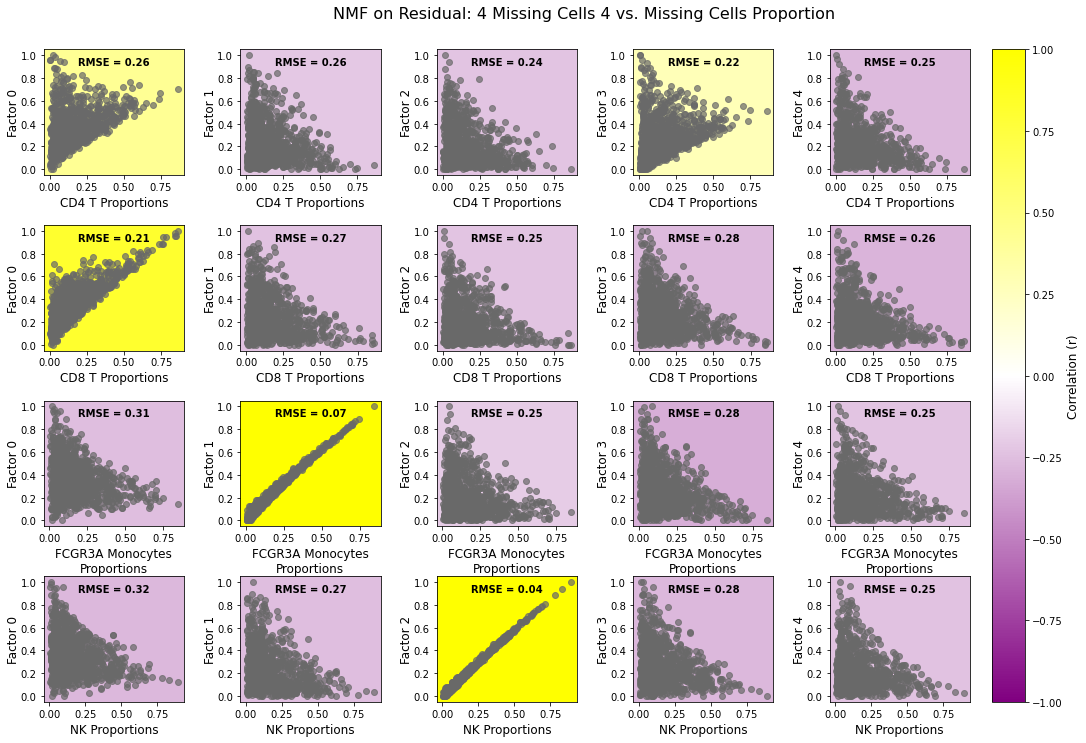

In [37]:
#NMF Residual(by sample) compared to each missing celltype proportion
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf, max_iter = 10000 ,init='nndsvd')
    res_nmf_df = nmf.fit_transform(residuals_shift_scaled[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
    #putting each component between 0 and 1 to match proportion range
    pseudo_raw_val = res_nmf_df.values 
    scaler = MinMaxScaler()
    scaler.fit(pseudo_raw_val)
    pseudo_scale = scaler.transform(pseudo_raw_val)
    res_nmf[num] = pd.DataFrame(pseudo_scale)
vp.factors_vs_proportions_rmse(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 

For comparison across deconvolution methods, see exploratory_experiments/EXP2_eval.ipynb